In [2]:
!dir data

 驱动器 C 中的卷没有标签。
 卷的序列号是 346F-7C10

 C:\Users\dell\Desktop\phasemapy\scripts_Cu-Fe-V-O\data 的目录

2022/09/05  16:23    <DIR>          .
2022/09/07  19:42    <DIR>          ..
2022/04/19  04:53             6,148 .DS_Store
2022/02/21  15:55            14,868 3577_CuFeV_compositions.csv
2022/02/21  15:55         3,686,692 Fe-Cu-V-609-Q666-inst_with28.txt
2022/05/06  20:41         8,806,997 Fe-Cu-V-O-raw_background.txt
2022/09/05  16:23    <DIR>          icdd
2022/06/07  17:17         1,264,567 icdd_entries.json
2022/04/21  16:38             3,717 kainotropite.cif
2022/02/21  15:55            10,638 pdfnames_list.txt
2022/02/21  15:55            11,649 pdfnames_list_normalizedComps.csv
2022/04/26  15:42        16,292,974 raw_data_Fe_Cu_V.txt
2022/05/18  08:49             1,110 SnO2_mp-856_symmetrized.cif
2022/02/21  15:55           364,014 VFeCuO_20200615174936.sticks
              11 个文件     30,463,374 字节
               3 个目录 327,881,781,248 可用字节


In [262]:
import json, os,sys
import numpy as np
sys.path.append('/Users/yizhou/PycharmProjects/phasemapy')
from copy import deepcopy
from pymatgen.core import Composition

In [263]:
from pymatgen.core import Element
from monty.json import MontyDecoder, MontyEncoder
from pymatgen.analysis.diffraction.xrd import XRDCalculator
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.io.cif import CifParser
import numpy as np
from phasemapy.dataio import InstanceData
from phasemapy.parser import ICDDEntry
from phasemapy.solver import Phase, Sample
import matplotlib.pyplot as plt
chemsys = ['Cu', 'Fe', 'V']
oxide_system = True
photon_e = 13e3
max_q_shift = 0.05
resample_density = 1000
initial_alphagamma = 0.1
SUM_NORM = 6000
loss_weight = {'xrd_loss': 6.0, 'comp_loss': 2.0, 'entropy_loss': 0.2}
instance_data = InstanceData.from_file('./data/Fe-Cu-V-O-raw_background.txt', chemsys, photon_e)

In [264]:
SnO2_file=np.loadtxt('PDF_Card_01-080-6417_SnO2.xy',skiprows=2).T 

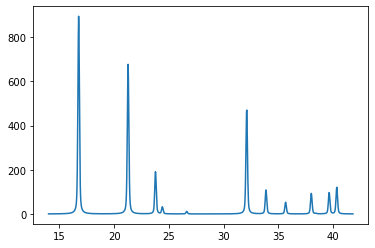

In [265]:
plt.plot(*SnO2_file)

In [266]:
SnO2 = CifParser('./data/SnO2_mp-856_symmetrized.cif').get_structures()[0]

spgr = SpacegroupAnalyzer(SnO2).get_space_group_symbol()
SnO2.lattice

Lattice
    abc : 3.243221 4.832336 4.832336
 angles : 90.0 90.0 90.0
 volume : 75.73398183153266
      A : -0.0 -0.0 3.243221
      B : 4.832336 -0.0 2.958952407402262e-16
      C : -2.958952407402262e-16 4.832336 2.958952407402262e-16

In [267]:
print (SnO2.lattice)

-0.000000 -0.000000 3.243221
4.832336 -0.000000 0.000000
-0.000000 4.832336 0.000000


In [268]:
#SnO2.apply_strain(0.03)

In [269]:
print (SnO2.lattice)

-0.000000 -0.000000 3.243221
4.832336 -0.000000 0.000000
-0.000000 4.832336 0.000000


In [270]:
SnO2_phase = ICDDEntry('01-000-0000', SnO2.composition.reduced_formula, 'Primary', 'Star', 'Ambient', None, spgr,
              'SnO2', [], SnO2)
SnO2_phase = ICDDEntry('01-000-0000', 'O2', 'Primary', 'Star', 'Ambient', None, spgr,
              'SnO2', [], SnO2)

In [274]:
with open('./data/icdd_entries.json') as f:
    entries = json.load(f, cls=MontyDecoder)
   

entries[-2].structure.lattice

Lattice
    abc : 3.17835658 4.73568928 4.73568928
 angles : 90.0 90.0 90.0
 volume : 71.28021782798389
      A : 0.0 0.0 3.17835658
      B : 4.73568928 0.0 2.8997733592542167e-16
      C : -2.8997733592542167e-16 4.73568928 2.8997733592542167e-16

In [275]:
entries[-2].composition

Comp: Sn1 O2

In [276]:
with open ('samples_near_volcano.xy') as f:
    lines = f.readlines()
print (lines[1])

Wavelength = 0.9764Å



In [277]:
data =np.loadtxt('samples_near_volcano.xy',skiprows=2).T
data.shape

(10, 1199)

In [278]:
twotheta = data[0]
new_q = np.sin(twotheta/2/360*np.pi*2)*2/0.9764*10*2*np.pi

In [279]:
new_sample_xrd = data[1:]

In [280]:
instance_data.comp_dict.keys()

dict_keys(['V', 'Cu', 'Fe'])

In [281]:
indexes = [83, 107, 108 ,109, 110,134,135,136,84]
new_comp_dict=dict()
for el in instance_data.comp_dict.keys():
    new_comp_dict[el]=np.array([instance_data.comp_dict[el][ i] for i in indexes])
new_comp_dict    

{'V': array([0.38 , 0.348, 0.365, 0.376, 0.388, 0.344, 0.357, 0.367, 0.394]),
 'Cu': array([0.504, 0.533, 0.511, 0.491, 0.471, 0.519, 0.497, 0.478, 0.484]),
 'Fe': array([0.116, 0.12 , 0.124, 0.132, 0.141, 0.137, 0.145, 0.155, 0.122])}

In [282]:
volcano_instance_data = InstanceData(chemsys,photon_e,np.log(new_q),new_sample_xrd,new_comp_dict)

In [283]:
entries[-2].composition = Composition.from_dict({el:amt for el,amt in zip(volcano_instance_data.chemsys,volcano_instance_data.sample_comp[0])})
entries[-2].composition
# new_q = np.sin(data[:,0]/180*np.pi)*4*np.pi/0.9764
# plt.plot(new_q,data[:,1])

Comp: V0.38 Fe0.116 Cu0.504

In [284]:
#instance_data.sample_xrd[83]=data[:,1]

In [285]:
# x = np.array([1,2,3,4,5,6]).reshape(2,3)
# y = np.array([1,2,1])
# x,y

In [286]:
#x [:,np.where(y<2)]

In [287]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [288]:

%autoreload 2

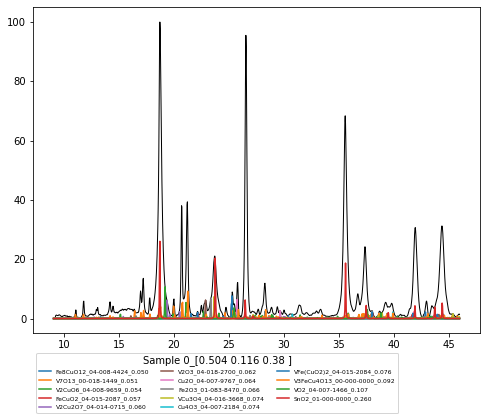

Sample: # 0
          Name     Entry_id  fraction     shift  width
0         SnO2  01-000-0000  0.075488 -0.006966   0.03
1          VO2  04-007-1466  0.161608 -0.048764   0.03
2   V3FeCu4O13  00-000-0000  0.100222  0.003483   0.03
3   VFe(CuO2)2  04-015-2084  0.065098  0.020899   0.03
4        Cu4O3  04-007-2184  0.048095  0.034832   0.03
5       VCu3O4  04-016-3668  0.057286 -0.031348   0.03
6        Fe2O3  01-083-8470  0.065508  0.020899   0.03
7         Cu2O  04-007-9767  0.040961  0.024382   0.03
8         V2O3  04-018-2700  0.084080 -0.034832   0.03
9      V2Cu2O7  04-014-0715  0.068268  0.010449   0.03
10      FeCuO2  04-015-2087  0.046285  0.027865   0.03
11      V2CuO6  04-008-9659  0.065394  0.048764   0.03
12       V7O13  00-018-1449  0.074834 -0.045281   0.03
13    Fe8CuO12  04-008-4424  0.046872  0.027865   0.03
Current R^2 = 0.8048039056822317


/Users/yizhou/PycharmProjects/phasemapy/phasemapy/solver.py:382: RuntimeWarning: invalid value encountered in true_divide
  basis_comp_np = basis_comp_np / np.sum(basis_comp_np, axis=1, keepdims=True)


x tensor([[0.0785, 0.0658, 0.0662, 0.0623, 0.1007, 0.0750, 0.0737, 0.0552, 0.0825,
         0.0740, 0.0692, 0.0570, 0.0587, 0.0814]], grad_fn=<SumBackward1>)
entropy tensor([2.6259], grad_fn=<NegBackward0>) tensor(2.6259, grad_fn=<MeanBackward0>)
loss tensor(0.8744, grad_fn=<DivBackward0>) tensor(2.6259, grad_fn=<MeanBackward0>) tensor(nan, grad_fn=<MseLossBackward0>)
0 nan tensor(0.8744) tensor(nan) tensor(2.6259)
x tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<SumBackward1>)


ValueError: Expected parameter probs (Tensor of shape (1, 14)) of distribution Categorical(probs: torch.Size([1, 14])) to satisfy the constraint Simplex(), but found invalid values:
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<DivBackward0>)

In [336]:
for i in [0]:
    solution=[]
    for e in entries:
        phase = Phase.from_entry_and_instance_data(e, 1 / len(entries), volcano_instance_data)
        solution.append(phase)

#     solution = [Phase.from_entry_and_instance_data(entries[-2], 0.5, volcano_instance_data,width=0.1),
#                 Phase.from_entry_and_instance_data(entries[-1], 0.5, volcano_instance_data,width=0.1)
#                ]    

    sample = Sample(i, volcano_instance_data.log_q, volcano_instance_data.sample_xrd[i], volcano_instance_data.chemsys,
                            volcano_instance_data.sample_comp[i], oxide_system, volcano_instance_data.wavelength, max_q_shift, solution)
    # sample.prune_candidates_based_on_composition(cutoff=0.05)
    sample.prune_candidate_based_on_xrd(plot=True, cutoff=0.05)
    sample.print_solution()
    new_sample = deepcopy(sample)
    new_sample = new_sample.optimize(num_epoch=500, print_prog=True, loss_weight=loss_weight)
    new_sample.refine_one_by_one()
    new_sample.refine_all_fractions()
    #new_sample = new_sample.optimize(num_epoch=500, print_prog=True, loss_weight=loss_weight)
    new_sample.refine_one_by_one()
    new_sample.refine_all_fractions()
    new_sample.print_solution()
    new_sample.plot(perphase=True)


In [51]:
new_sample = deepcopy(sample)
# new_sample = new_sample.optimize(num_epoch=500, print_prog=True, loss_weight=loss_weight)
new_sample.refine_one_by_one()
new_sample.refine_all_fractions()
#new_sample = new_sample.optimize(num_epoch=500, print_prog=True, loss_weight=loss_weight)
new_sample.refine_one_by_one()
new_sample.refine_all_fractions()
new_sample.print_solution()
new_sample.plot(perphase=True)

ValueError: not enough values to unpack (expected 2, got 0)

In [ ]:
class InstanceData:

    def __init__(self, chemsys, photon_e, log_q, sample_xrd, comp_dict):
        self.chemsys = sorted(chemsys)
        self.log_q = log_q
        self.sample_xrd = sample_xrd
        self.comp_dict = comp_dict
        self.photon_e = photon_e
        self.wavelength = 1e10 * h * c / (self.photon_e * e)  # in A

In [ ]:
ICDDEntry

In [ ]:
PDF_Card_01-080-6417_SnO2.xy